# ResBlock MLP Network with Hadamard Layer


## 1. Pretreatment


Read data from `.mat` files.

In [1]:
import scipy as sp
import matplotlib.pyplot as plt
import numpy as np
import yaml

import torch
import torch.nn as nn
from torchinfo import summary

with open("./config/NoSC_ResBlock.yaml", "r") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

Import data.

In [2]:
InputData = sp.io.loadmat(config["DATA_LOADER"]["INPUT_DATA_PATH"])["KinematicsData"]
OutputData = sp.io.loadmat(config["DATA_LOADER"]["OUTPUT_DATA_PATH"])["DynRegData"]

Import `NN_utils` and `Visualization`.

In [3]:
import sys

sys.path.append("../utils")
from Blocks import *
from NN_utils import *
from Visualization import *

SETUP_SEED(42)
torch.set_default_dtype(torch.float64)

Size of input and output data.

In [4]:
InputData.shape, OutputData.shape

((50000, 8), (50000, 14))

Create **Training**, **Validation** and **Test** datasets.

In [5]:
InputData = torch.from_numpy(InputData)
OutputData = torch.from_numpy(OutputData)
TrainingLoader, ValidationLoader, TestLoader = Split2Loaders(
    InputData, OutputData, config
)

## 2. Training


Define MLP network structure.

In [6]:
class DynReg_MLP(nn.Module):
    def __init__(
        self,
        input_size,
        output_size,
        embedding_size,
        ResBlock_size=None,
        ResBlock_hidden_size=None,
        sliding_pair=True,
        hadmard_bias=True,
        shortcut=True,
    ):
        if ResBlock_size is None or ResBlock_hidden_size is None:
            ResBlock_size = [16, 32, 16]
            ResBlock_hidden_size = [16, 32, 16, 16]
        super().__init__()
        # Degree of Freedom
        self.DoF = input_size // 4
        # Triangular Layer
        self.TrigLayer = Triangular(SlidingPair=sliding_pair)
        # Linear Layer List
        self.NN = nn.ModuleList()
        self.NNStruct = (
            [input_size + self.DoF * (sliding_pair + 1)]
            + ResBlock_size
            + [embedding_size]
        )
        for i in range(len(self.NNStruct) - 1):
            self.NN.append(
                ResLinear(
                    input_size=self.NNStruct[i],
                    output_size=self.NNStruct[i + 1],
                    hidden_size=(
                        ResBlock_hidden_size[i]
                        if ResBlock_hidden_size[i] is not None
                        else None
                    ),
                )
            )
        self.Hadamard = HadamardProduct(embedding_size, bias=hadmard_bias)
        self.LinearMapping = nn.Linear(embedding_size, output_size, bias=False)
        if shortcut:
            self.Shortcut = ShortcutMapping(input_size, embedding_size)
        else:
            self.register_parameter("Shortcut", None)

    def forward(self, x):
        Output = self.TrigLayer(x)
        for layer in self.NN:
            Output = layer(Output)
        if self.Shortcut is not None:
            Output = self.Hadamard(Output) + self.Shortcut(x)
        else:
            Output = self.Hadamard(Output)
        return self.LinearMapping(Output)

Define network.

In [7]:
Net = DynReg_MLP(
    input_size=config["NETWORK"]["INPUT_SIZE"],
    output_size=config["NETWORK"]["OUTPUT_SIZE"],
    embedding_size=config["NETWORK"]["EMBEDDING_SIZE"],
    ResBlock_size=config["NETWORK"]["RES_BLOCK_SIZE"],
    ResBlock_hidden_size=config["NETWORK"]["RES_BLOCK_HIDDEN_SIZE"],
    sliding_pair=False,
    hadmard_bias=True,
    shortcut=False,
)

Summary.

In [8]:
summary(
    Net,
    input_data=torch.zeros(1, InputData.shape[1]),
    device=GET_DEVICE(),
    col_names=["input_size", "output_size", "num_params"],
    col_width=15,
)

Layer (type:depth-idx)                   Input Shape     Output Shape    Param #
DynReg_MLP                               [1, 8]          [1, 14]         --
├─Triangular: 1-1                        [1, 8]          [1, 10]         --
├─ModuleList: 1-2                        --              --              --
│    └─ResLinear: 2-1                    [1, 10]         [1, 32]         --
│    │    └─Linear: 3-1                  [1, 10]         [1, 32]         352
│    │    └─Linear: 3-2                  [1, 32]         [1, 32]         1,056
│    │    └─Linear: 3-3                  [1, 10]         [1, 32]         320
│    └─ResLinear: 2-2                    [1, 32]         [1, 8]          --
│    │    └─Linear: 3-4                  [1, 32]         [1, 32]         1,056
│    │    └─Linear: 3-5                  [1, 32]         [1, 8]          264
│    │    └─Linear: 3-6                  [1, 32]         [1, 8]          256
├─HadamardProduct: 1-3                   [1, 8]          [1, 8]          

Define loss function.

In [9]:
def SparityLoss(SparityPromotingLayer, OutputFromNet, OutputFromData):
    sparity_loss = 0
    for layer in SparityPromotingLayer:
        for _, param in layer.named_parameters():
            sparity_loss += torch.abs(param).sum()

    return sparity_loss

Define optimizer.

In [10]:
optimizer = torch.optim.Adam(
    Net.parameters(),
    lr=config["TRAIN"]["LEARNING_RATE"],
    weight_decay=config["TRAIN"]["WEIGHT_DECAY"],
)

Training network.

In [11]:
(
    Loss_1_Training_History,
    Loss_1_Validation_History,
    Loss_2_Training_History,
    Loss_2_Validation_History,
) = TRAIN_WITH_PROGRESS_BAR_TWO_LOSS(
    MODEL=Net,
    CONFIG=config,
    OPTIMIZER=optimizer,
    TRAIN_LOADER=TrainingLoader,
    VALIDATION_LOADER=ValidationLoader,
    LOSS_TUPLE=[
        nn.MSELoss(),
        lambda y1, y2: SparityLoss(
            [Net.LinearMapping],
            y1,
            y2,
        ),
    ],
    FREEZE_LAYER=[Net.LinearMapping],
)

PyTorch Version: 2.5.1
Weight initialized with Kaiming Initialization
Training on cpu
====================================Start training====================================


Epoch 100/100: 100%|██████████| 938/938 [00:04<00:00, 201.37batch/s, loss_1=0.225, loss_2=0.0611]


====================================Finish training====================================



## 3. Visualization

Loss-Epoch Diagram

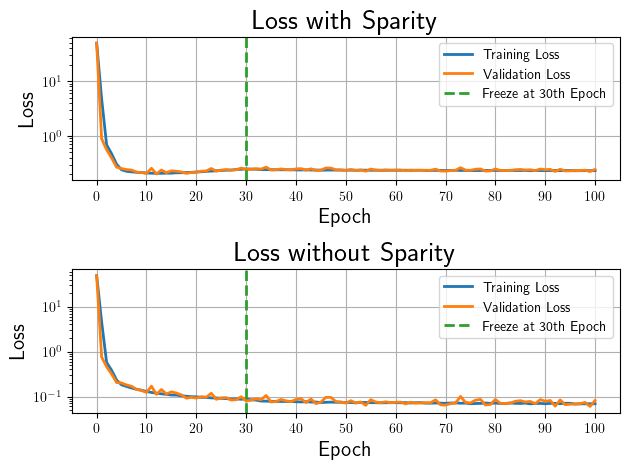

In [12]:
plt.rcParams["text.usetex"] = True
Loss_Epoch_Diagram = LOSS_EPOCH_DIAGRAM_TWO_LOSS(
    LOSS_HISTORY_TUPLE=(
        Loss_1_Training_History,
        Loss_1_Validation_History,
        Loss_2_Training_History,
        Loss_2_Validation_History,
    ),
    CONFIG=config,
    LAYER_NAME=["Shortcut", "LinearMapping"],
)

Final loss.

In [13]:
Loss_2_Training_History[-1], Loss_2_Validation_History[-1]

(0.06908947002523519, 0.08156234963587344)

Linear Mapping Matrix Visualization.

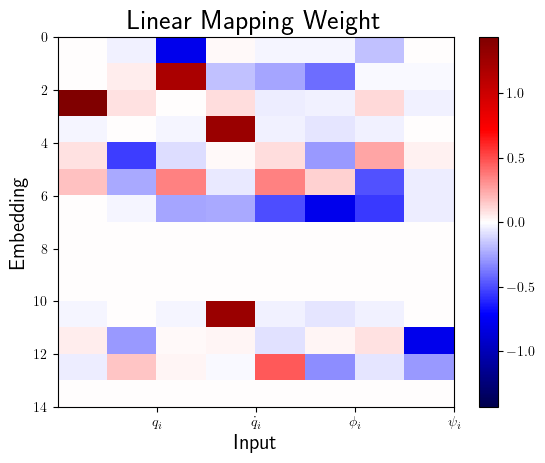

In [14]:
data_temp = Net.LinearMapping.weight.detach().to("cpu").numpy()
Linear_Mapping_Weight = VISUALIZE_MATRIX(
    data_temp, config["VISUALIZATION"]["LINEAR_MAPPING_WEIGHT"], "Linear Mapping Weight"
)
Linear_Mapping_Weight.gca().set_xlabel("Input", fontsize=15)
Linear_Mapping_Weight.gca().set_ylabel("Embedding", fontsize=15)
Linear_Mapping_Weight.gca().set_xticks(
    config["NETWORK"]["INPUT_SIZE"] // 4 * np.arange(1, 5)
)
Linear_Mapping_Weight.gca().set_xticklabels(
    [
        r"$q_{i}$",
        r"$\dot{q}_{i}$",
        r"$\phi_{i}$",
        r"$\psi_{i}$",
    ]
)
plt.show()

Hadmard Layer Visualization.

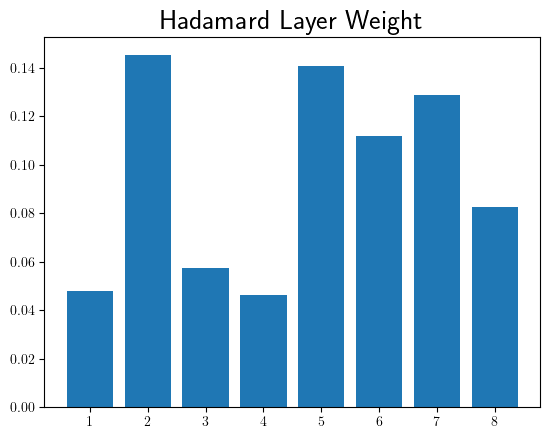

In [15]:
plt.bar(
    np.arange(1, config["NETWORK"]["EMBEDDING_SIZE"] + 1),
    Net.Hadamard.weight.detach().to("cpu").numpy(),
)
plt.title("Hadamard Layer Weight", fontsize=20)
plt.show()

Linear Layer Weight Visualization.

In [16]:
def VISUALIZE_ResBlockWeight(NN, CONFIG):
    NUM_LAYERS = len(NN)
    if CONFIG["NUM_ROW"] == -1 or CONFIG["NUM_COL"] == -1:
        NUM_ROW = NUM_LAYERS
        NUM_COL = 3
    else:
        NUM_ROW = CONFIG["NUM_ROW"]
        NUM_COL = CONFIG["NUM_COL"]
    INPUT_SHAPE = NN[0].Linear_1.weight.shape[1]
    FIG_SIZE = [3 * 4, NUM_ROW * 4]
    fig, ax = plt.subplots(NUM_ROW, NUM_COL, figsize=FIG_SIZE, dpi=CONFIG["DPI"])
    for i in range(NUM_LAYERS):
        VISUALIZE_MATRIX_AX(
            ax[i, 0],
            NN[i].Linear_1.weight.detach().to("cpu").numpy(),
            CONFIG,
            f"ResBlock {i+1}'s Linear 1 Weight",
        )
        VISUALIZE_MATRIX_AX(
            ax[i, 1],
            NN[i].Linear_2.weight.detach().to("cpu").numpy(),
            CONFIG,
            f"ResBlock {i+1}'s Linear 2 Weight",
        )
        VISUALIZE_MATRIX_AX(
            ax[i, 2],
            NN[i].Shortcut.weight.detach().to("cpu").numpy(),
            CONFIG,
            f"ResBlock {i+1}'s Shortcut Weight",
        )
        if i == 0:
            ax[i, 0].set_xticks(
                int(INPUT_SHAPE / (5 + CONFIG["SLIDING_PAIR"]))
                * np.arange(1, 6 + CONFIG["SLIDING_PAIR"])
            )
            ax[i, 2].set_xticks(
                int(5 + CONFIG["SLIDING_PAIR"])
                * np.arange(1, 6 + CONFIG["SLIDING_PAIR"])
            )
            TickLabels = [
                r"$\sin(q_{i})$",
                r"$\cos(q_{i})$",
                r"$\dot{q}_{i}$",
                r"$\phi_{i}$",
                r"$\psi_{i}$",
            ]
            if CONFIG["SLIDING_PAIR"]:
                TickLabels = [r"$q_{i}$"] + TickLabels
            ax[i, 0].set_xticklabels(TickLabels)
            ax[i, 2].set_xticklabels(TickLabels)
    plt.tight_layout()
    return fig

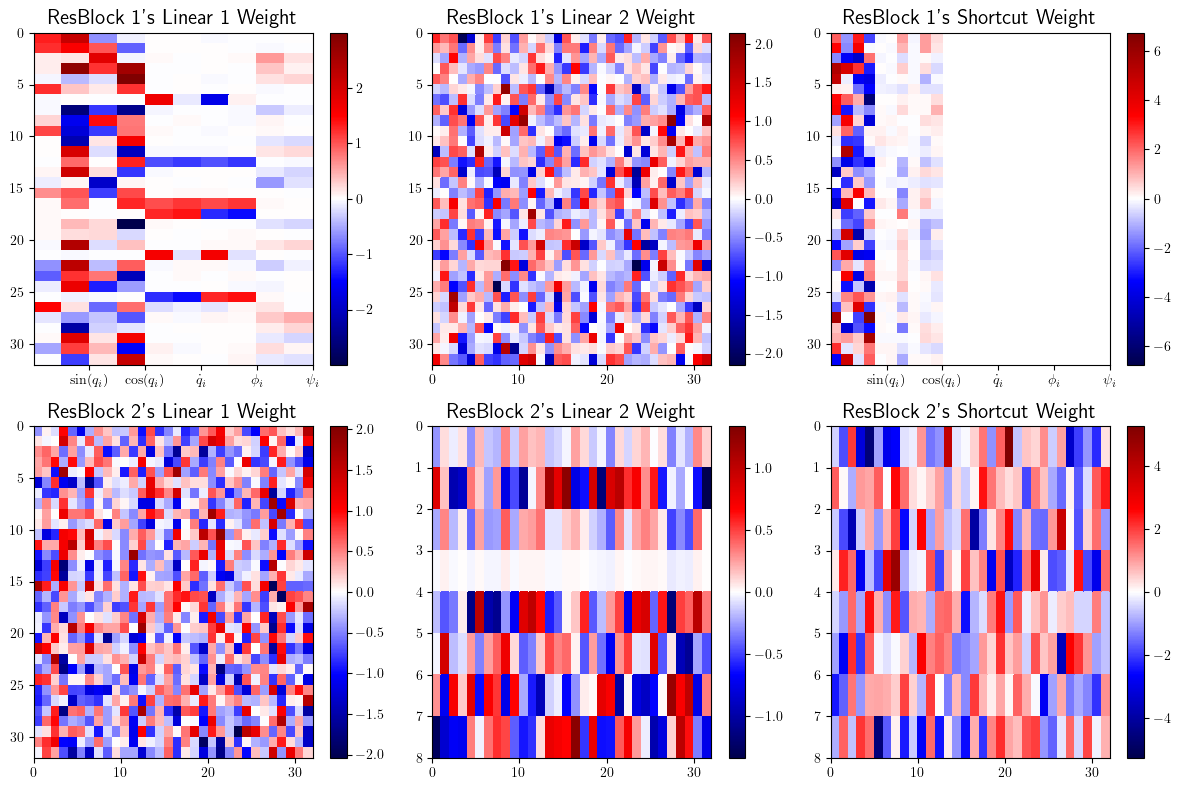

In [17]:
NN_Weight = VISUALIZE_ResBlockWeight(Net.NN, config["VISUALIZATION"]["NN_WEIGHT"])

## 4. Error on Test Data

Test Data

In [18]:
test_input_data = []
test_output_data = []
for data in TestLoader:
    test_input_data += data[0].detach().to(GET_DEVICE(config["TRAIN"]["DEVICE"]))
    test_output_data += data[1].detach().to("cpu")

test_output_fromData = torch.stack(test_output_data).numpy()

Obtain output computed from model.

In [19]:
Net.eval()
test_ouput_fromModel = (
    torch.stack([Net(test_input) for test_input in test_input_data])
    .to("cpu")
    .detach()
    .numpy()
)

Compute standard deviation and extreme error of each element.

In [20]:
import itertools

StandardDeviation = np.zeros((1, test_ouput_fromModel.shape[1]))
ExtremeError = test_ouput_fromModel[:2, :] - test_output_fromData[:2, :]
for i, j in itertools.product(
    range(test_ouput_fromModel.shape[0]), range(test_ouput_fromModel.shape[1])
):
    StandardDeviation[:, j] += np.power(
        test_ouput_fromModel[i, j] - test_output_fromData[i, j], 2
    )
    ExtremeError[0, j] = max(
        ExtremeError[0, j], (test_ouput_fromModel[i, j] - test_output_fromData[i, j])
    )
    ExtremeError[1, j] = min(
        ExtremeError[1, j], (test_ouput_fromModel[i, j] - test_output_fromData[i, j])
    )
StandardDeviation = np.sqrt(StandardDeviation) / test_ouput_fromModel.shape[0]
StandardDeviation = StandardDeviation.reshape(
    -1,
).tolist()
UpperError = ExtremeError[0, :].tolist()
LowerError = ExtremeError[1, :].tolist()

Visualization.

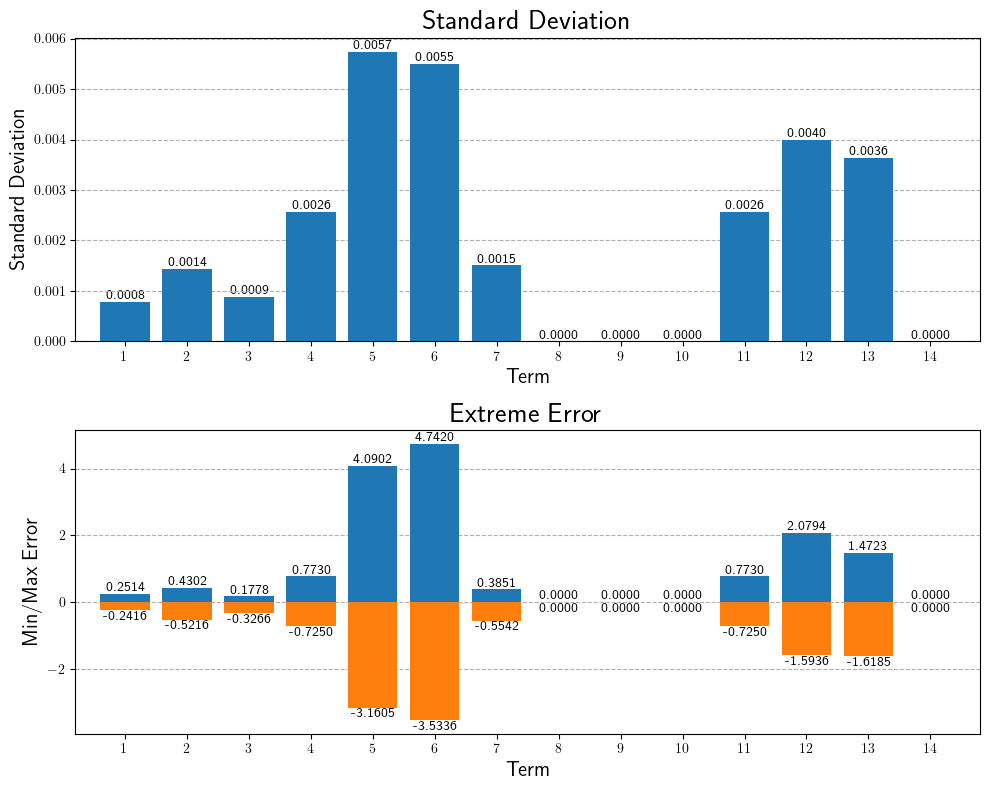

In [21]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Standard Deviation
axs[0].bar(np.arange(len(StandardDeviation)) + 1, StandardDeviation, zorder=5)
for i in range(len(StandardDeviation)):
    axs[0].text(
        i + 1,
        StandardDeviation[i],
        "{:.4f}".format(StandardDeviation[i]),
        ha="center",
        va="bottom",
        zorder=1,
    )
axs[0].set_xticks(np.arange(len(StandardDeviation)) + 1)
axs[0].set_xlim([1 - 0.8, len(StandardDeviation) + 0.8])
axs[0].set_title("Standard Deviation", fontsize=20)
axs[0].set_xlabel("Term", fontsize=15)
axs[0].set_ylabel("Standard Deviation", fontsize=15)
axs[0].grid(axis="y", linestyle="--", zorder=0)


# Upper Error
axs[1].bar(np.arange(len(UpperError)) + 1, UpperError, zorder=5)
# Lower Error
axs[1].bar(np.arange(len(LowerError)) + 1, LowerError, zorder=5)
for i in range(len(UpperError)):
    axs[1].text(
        i + 1,
        UpperError[i],
        "{:.4f}".format(UpperError[i]),
        ha="center",
        va="bottom",
        zorder=1,
    )
    axs[1].text(
        i + 1,
        LowerError[i],
        "{:.4f}".format(LowerError[i]),
        ha="center",
        va="top",
        zorder=1,
    )
axs[1].set_xticks(np.arange(len(UpperError)) + 1)
axs[1].set_xlim([1 - 0.8, len(UpperError) + 0.8])
axs[1].set_title("Extreme Error", fontsize=20)
axs[1].set_xlabel("Term", fontsize=15)
axs[1].set_ylabel("Min/Max Error", fontsize=15)
axs[1].grid(axis="y", linestyle="--", zorder=0)

plt.tight_layout()
plt.show()

Histogram of dominating error terms.

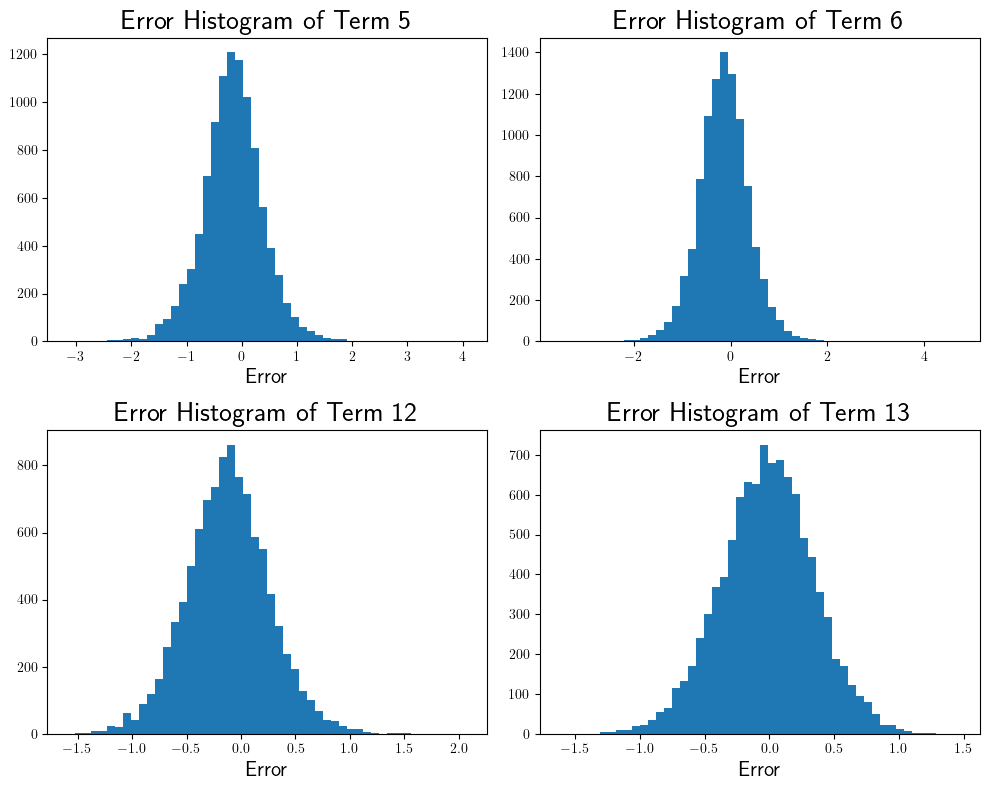

In [22]:
HistedTermIndex = [4, 5, 11, 12]
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

for i in range(4):
    axs[int(np.floor(i / 2)), np.mod(i, 2)].hist(
        test_ouput_fromModel[:, HistedTermIndex[i]]
        - test_output_fromData[:, HistedTermIndex[i]],
        bins=50,
    )
    axs[int(np.floor(i / 2)), np.mod(i, 2)].set_xlabel("Error", fontsize=15)
    axs[int(np.floor(i / 2)), np.mod(i, 2)].set_title(
        f"Error Histogram of Term {HistedTermIndex[i]+1}", fontsize=20
    )

plt.tight_layout()
plt.show()